# MultiClass Classification to determine in which period band engine will fail

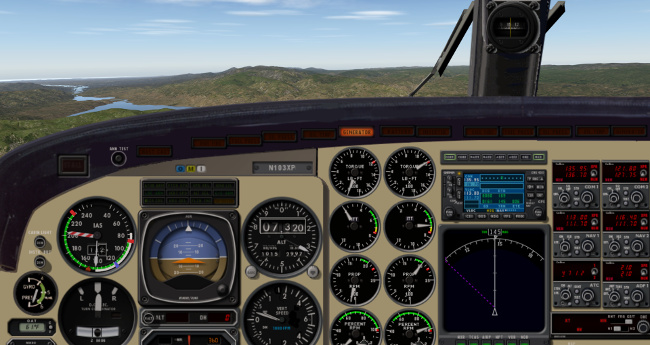

# Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  
from itertools import cycle
from sklearn import metrics
from sklearn import model_selection
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler, LabelBinarizer

### Load Data:

In [2]:
# load training data 
df_train = pd.read_csv('train.csv')
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.008697,0.0,0.000000,0.0,0.0,0.042426,0.003253,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.007640,0.0,1.154701,0.0,0.0,0.055076,0.044573,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.028117,0.0,1.000000,0.0,0.0,0.076322,0.037977,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.025953,0.0,1.095445,0.0,0.0,0.073621,0.033498,187,0,0


In [3]:
# load test data 
df_test = pd.read_csv('test.csv')
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,0.021174,0.0,0.707107,0.0,0.0,0.124016,0.025037,112,0,0
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,...,0.011429,0.0,1.095445,0.0,0.0,0.069785,0.027820,98,0,0
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,...,0.030924,0.0,0.836660,0.0,0.0,0.143631,0.018966,69,0,0
3,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,...,0.021249,0.0,1.341641,0.0,0.0,0.126372,0.021106,82,0,0
4,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,...,0.009627,0.0,0.547723,0.0,0.0,0.091924,0.101100,91,0,0


Create features sets required to subset the original dataframes into original features and original + extracted features

Create training and test data labels series, and convert them to binary format as required by multiclass classification algorithms.


In [4]:
# original features
features_orig = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

# original + extracted fetures
features_extr = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'av1', 'av2', 'av3', 'av4', 'av5', 'av6', 'av7', 'av8', 'av9', 'av10', 'av11', 'av12', 'av13', 'av14', 'av15', 'av16', 'av17', 'av18', 'av19', 'av20', 'av21', 'sd1', 'sd2', 'sd3', 'sd4', 'sd5', 'sd6', 'sd7', 'sd8', 'sd9', 'sd10', 'sd11', 'sd12', 'sd13', 'sd14', 'sd15', 'sd16', 'sd17', 'sd18', 'sd19', 'sd20', 'sd21']

y_train = df_train['label_mcc']
y_test = df_test['label_mcc']

lb = LabelBinarizer()

y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)


### Multiclass Classification:

Define helper fuctions

In [5]:
#@title MultiClass-Classify function
def multiclass_classify(model, clf, features, params=None, score=None, scale=False, OvR=True, prob='P'):
    X_train = df_train[features]
    X_test = df_test[features]  
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)  
    if prob == 'P':   
        y_score = grid_search.predict_proba(X_test)
        if OvR:    
            y_score = [y_score[i][:,[1]] for i in range(len(y_score))]
            y_score = np.concatenate(y_score, axis=1)
    elif prob == 'D':
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred 
    return grid_search.best_estimator_, y_pred, y_score


In [6]:
#@title Multi-class Metric function
def multiclass_metrics(model, y_test, y_pred, y_score, print_out=True, plot_out=True):
    multiclass_metrics = {
                            'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                            'macro F1' : metrics.f1_score(y_test, y_pred, average='macro'),
                            'micro F1' : metrics.f1_score(y_test, y_pred, average='micro'),
                            'macro Precision' : metrics.precision_score(y_test, y_pred,  average='macro'),
                            'micro Precision' : metrics.precision_score(y_test, y_pred,  average='micro'),
                            'macro Recall' : metrics.recall_score(y_test, y_pred,  average='macro'),
                            'micro Recall' : metrics.recall_score(y_test, y_pred,  average='micro'),
                            'macro ROC AUC' : metrics.roc_auc_score(y_test, y_score, average='macro'),
                            'micro ROC AUC' : metrics.roc_auc_score(y_test, y_score, average='micro')
                        } 
    df_metrics = pd.DataFrame.from_dict(multiclass_metrics, orient='index')
    df_metrics.columns = [model] 
    n_classes = y_train.shape[1] 
    fpr = dict()
    tpr = dict()
    thresh_roc = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], thresh_roc[i] = metrics.roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], thresh_roc["micro"] = metrics.roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    roc_thresh = {
                    'Threshold' : thresh_roc,
                    'TPR' : tpr,
                    'FPR' : fpr,
                    'AUC' : roc_auc
                 }
    df_roc_thresh = pd.DataFrame.from_dict(roc_thresh)
    df_roc_thresh['Model'] = model
    df_roc_thresh['Class'] = df_roc_thresh.index
    precision = dict()
    recall = dict()
    thresh_prc = dict()
    average_precision = dict() 
    for i in range(n_classes):
        #precision[i], recall[i], thresh_prc[i] = metrics.precision_recall_curve(y_test[:, i], y_score[i][:,0])
        precision[i], recall[i], thresh_prc[i] = metrics.precision_recall_curve(y_test[:, i], y_score[:, i])
        average_precision[i] = metrics.average_precision_score(y_test[:, i], y_score[:, i])
    precision["micro"], recall["micro"], thresh_prc["micro"] = metrics.precision_recall_curve(y_test.ravel(), y_score.ravel())
    average_precision["micro"] = metrics.average_precision_score(y_test, y_score, average="micro")
    prc_thresh = {
                    'Threshold' : thresh_prc,
                    'Precision' : precision,
                    'Recall' : recall,
                    'Avg Precision' : average_precision
                 }
    df_prc_thresh = pd.DataFrame.from_dict(prc_thresh)
    df_prc_thresh['Model'] = model
    df_prc_thresh['Class'] = df_prc_thresh.index    
    y_test_orig = lb.inverse_transform(y_test)
    y_pred_orig = lb.inverse_transform(y_pred)
    if print_out:
        print('-----------------------------------------------------------')
        print(model, '\n')
        print('Confusion Matrix:')
        print(metrics.confusion_matrix(y_test_orig, y_pred_orig))
        print('\nClassification Report:')
        print(metrics.classification_report(y_test_orig, y_pred_orig))
        print('\nMetrics:')
        print(df_metrics)
    if plot_out:  
        colors = cycle(['red', 'green', 'blue'])
        
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False )
        fig.set_size_inches(12,6)
        
        for i, color in zip(range(n_classes), colors):
            ax1.plot(fpr[i], tpr[i], color=color, lw=1, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
        
        ax1.plot(fpr["micro"], tpr["micro"], color='deeppink', label='micro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["micro"]), linestyle=':', linewidth=4)
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax1.set_xlim([-0.05, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend(loc="lower right", fontsize='small')
        for i, color in zip(range(n_classes), colors):
            ax2.plot(recall[i], precision[i], color=color, lw=1, label='Precision-recall curve of class {0} (area = {1:0.2f})'.format(i, average_precision[i]))
            
        ax2.plot(recall["micro"], precision["micro"], color='deeppink', lw=4, linestyle=':', label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.legend(loc="lower left", fontsize='small')
    return df_metrics, df_prc_thresh, df_roc_thresh

Using the above functions let us model and evaluate some binary classification algorithms

__In model names:__  

__B__ stands for applying the model on the original features set, __Before feature extraction  
__A__ stands for applying the model on the original + extracted features set, __After feature extraction

# Decision Tree Classifier

Before Feature Extraction


Best Parameters:
 DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=123)
-----------------------------------------------------------
Decision Tree B 

Confusion Matrix:
[[74  1  0]
 [12  2  1]
 [ 1  0  9]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.91        75
           1       0.67      0.13      0.22        15
           2       0.90      0.90      0.90        10

    accuracy                           0.85       100
   macro avg       0.81      0.67      0.68       100
weighted avg       0.83      0.85      0.81       100


Metrics:
                 Decision Tree B
Accuracy                0.840000
macro F1                0.684053
micro F1                0.861538
macro Precision         0.818970
micro Precision         0.884211
macro Recall            0.668889
micro Recall            0.840000
macro ROC AUC           0.905594
micro ROC AUC           0.956625


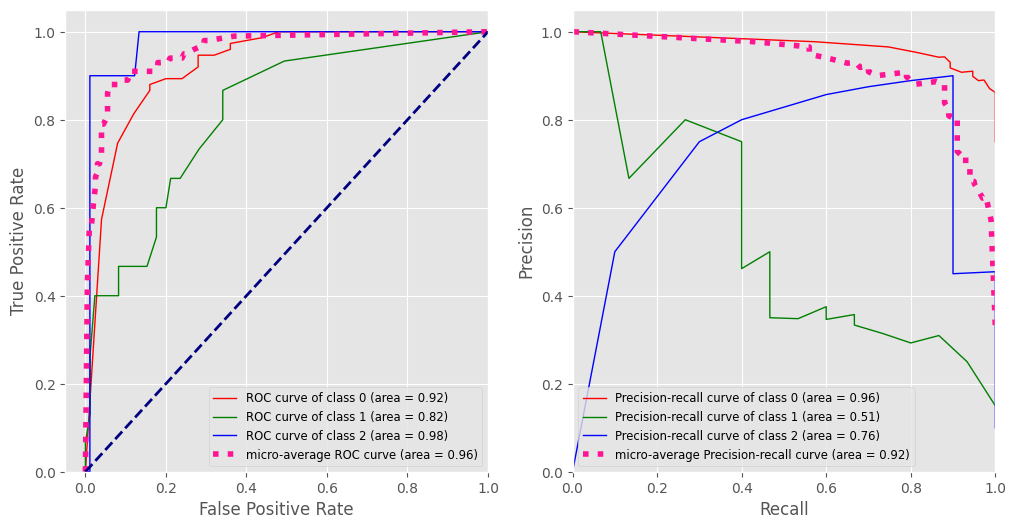

In [7]:
model = 'Decision Tree B'
clf_dtrb = DecisionTreeClassifier(random_state=123)
gs_params = {'max_depth': [ 4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'
clf_dtrb, y_pred_dtrb, y_score_dtrb = multiclass_classify(model, clf_dtrb, features_orig, params=gs_params, score=gs_score, scale=False, OvR=True, prob='P')
print('\nBest Parameters:\n',clf_dtrb)
metrics_dtrb, prc_dtrb, roc_dtrb = multiclass_metrics(model, y_test, y_pred_dtrb, y_score_dtrb, print_out=True, plot_out=True)


After Feature Extraction


Best Parameters:
 DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=123)
-----------------------------------------------------------
Decision Tree A 

Confusion Matrix:
[[74  0  1]
 [10  1  4]
 [ 1  0  9]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93        75
           1       1.00      0.07      0.12        15
           2       0.64      0.90      0.75        10

    accuracy                           0.84       100
   macro avg       0.84      0.65      0.60       100
weighted avg       0.87      0.84      0.79       100


Metrics:
                 Decision Tree A
Accuracy                0.840000
macro F1                0.607906
micro F1                0.857143
macro Precision         0.852146
micro Precision         0.875000
macro Recall            0.651111
micro Recall            0.840000
macro ROC AUC           0.949857
micro ROC AUC           0.973550


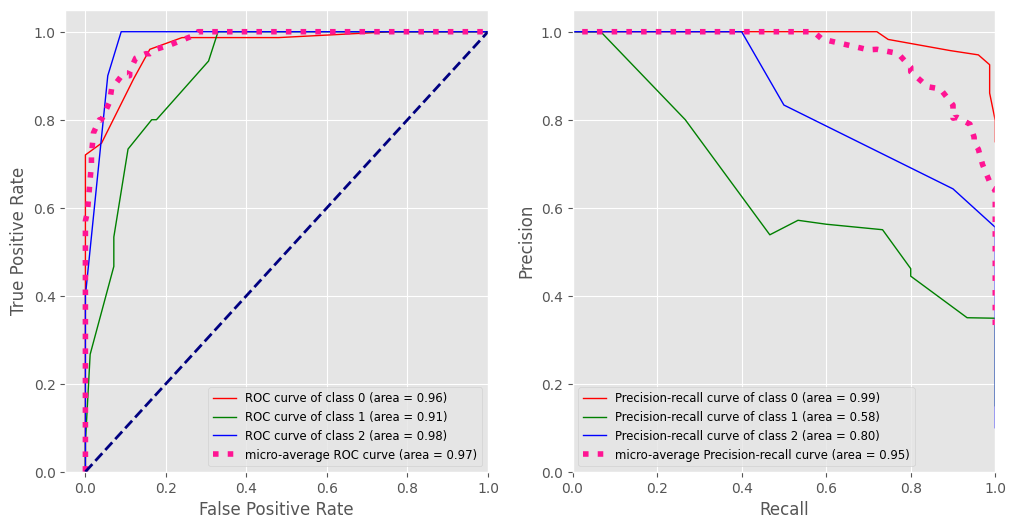

In [8]:
model = 'Decision Tree A'
clf_dtra = DecisionTreeClassifier(random_state=123)
gs_params = {'max_depth': [ 4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'
clf_dtra, y_pred_dtra, y_score_dtra = multiclass_classify(model, clf_dtrb, 
                                            features_extr, params=gs_params, score=gs_score, scale=False, OvR=True, prob='P')
print('\nBest Parameters:\n',clf_dtra)
metrics_dtra, prc_dtra, roc_dtra = multiclass_metrics(model, y_test, y_pred_dtra, y_score_dtra, print_out=True, plot_out=True)


In [9]:
metrics_dtr = pd.concat([metrics_dtrb, metrics_dtra], axis=1)
metrics_dtr

,Decision Tree B,Decision Tree A
Accuracy,0.840000,0.840000
macro F1,0.684053,0.607906
micro F1,0.861538,0.857143
macro Precision,0.818970,0.852146
micro Precision,0.884211,0.875000
macro Recall,0.668889,0.651111
micro Recall,0.840000,0.840000
macro ROC AUC,0.905594,0.949857
micro ROC AUC,0.956625,0.973550


# Logisic Regression

Before Feature Extraction

C:\Users\harsh\.conda\envs\h\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\harsh\.conda\envs\h\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 


Best Parameters:
 OneVsRestClassifier(estimator=LogisticRegression(C=0.01, random_state=123))
-----------------------------------------------------------
Logistic Regression B 

Confusion Matrix:
[[75  0  0]
 [13  0  2]
 [ 3  0  7]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        75
           1       0.00      0.00      0.00        15
           2       0.78      0.70      0.74        10

    accuracy                           0.82       100
   macro avg       0.53      0.57      0.55       100
weighted avg       0.70      0.82      0.75       100


Metrics:
                 Logistic Regression B
Accuracy                      0.810000
macro F1                      0.552032
micro F1                      0.830769
macro Precision               0.546081
micro Precision               0.852632
macro Recall                  0.562222
micro Recall                  0.810000
macro ROC AUC                 0.942605


C:\Users\harsh\.conda\envs\h\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harsh\.conda\envs\h\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harsh\.conda\envs\h\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harsh\.conda\envs\h\lib\site-packages\sklearn\m

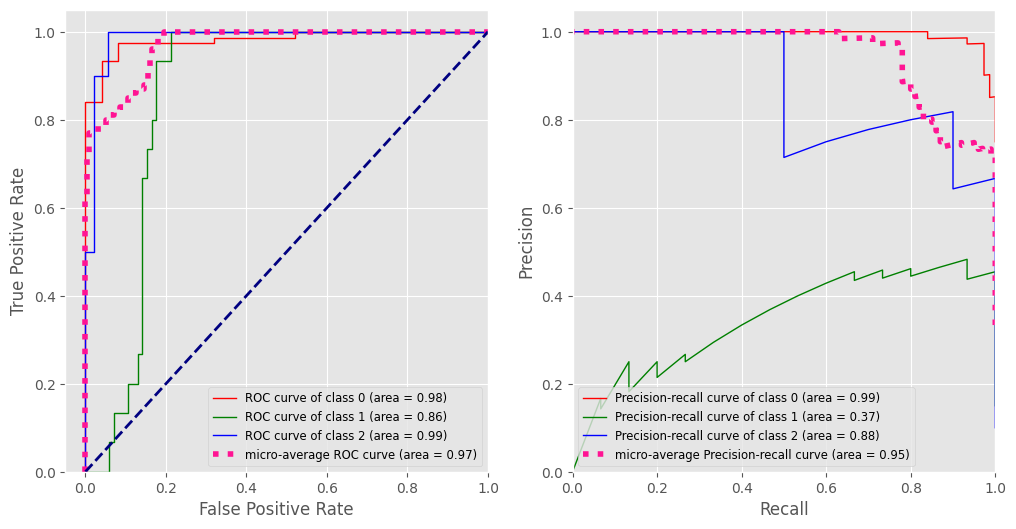

In [10]:
model = 'Logistic Regression B'

clf_lgrb = OneVsRestClassifier(LogisticRegression(random_state=123))
gs_params = {'estimator__C': [.01, 0.1, 1.0, 10], 'estimator__solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'


clf_lgrb, y_pred_lgrb, y_score_lgrb = multiclass_classify(model, clf_lgrb, features_orig, params=gs_params, score=gs_score, scale=False, OvR=False)
print('\nBest Parameters:\n',clf_lgrb)

metrics_lgrb, prc_lgrb, roc_lgrb = multiclass_metrics(model, y_test, y_pred_lgrb, y_score_lgrb, print_out=True, plot_out=True)


After Feature Extraction

C:\Users\harsh\.conda\envs\h\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Best Parameters:
 OneVsRestClassifier(estimator=LogisticRegression(C=10, random_state=123))
-----------------------------------------------------------
Logistic Regression A 

Confusion Matrix:
[[75  0  0]
 [14  0  1]
 [ 4  0  6]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        75
           1       0.00      0.00      0.00        15
           2       0.86      0.60      0.71        10

    accuracy                           0.81       100
   macro avg       0.55      0.53      0.53       100
weighted avg       0.69      0.81      0.74       100


Metrics:
                 Logistic Regression A
Accuracy                      0.810000
macro F1                      0.551750
micro F1                      0.852632
macro Precision               0.586919
micro Precision               0.900000
macro Recall                  0.533333
micro Recall                  0.810000
macro ROC AUC                 0.941515
mi

C:\Users\harsh\.conda\envs\h\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harsh\.conda\envs\h\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harsh\.conda\envs\h\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\harsh\.conda\envs\h\lib\site-packages\sklearn\m

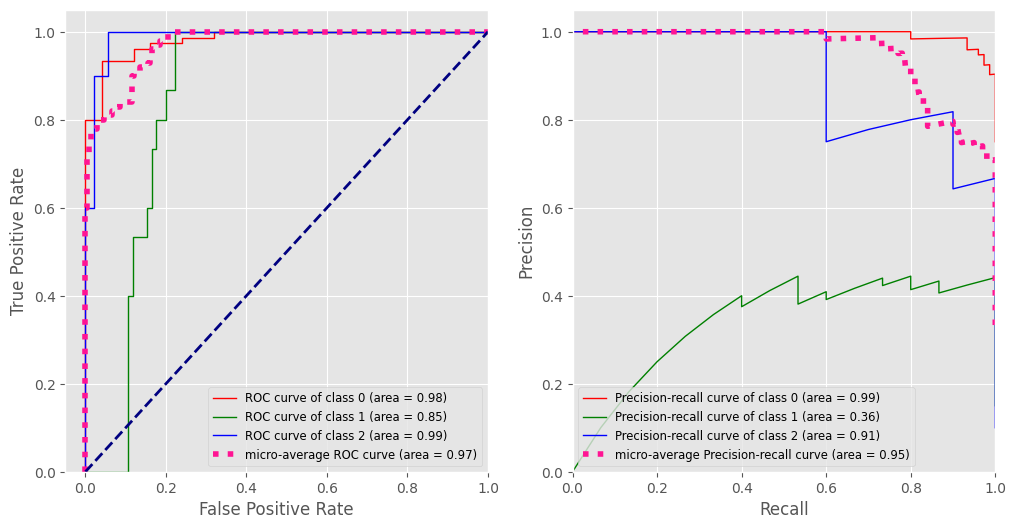

In [11]:
model = 'Logistic Regression A'

clf_lgra = OneVsRestClassifier(LogisticRegression(random_state=123))
gs_params = {'estimator__C': [.01, 0.1, 1.0, 10], 'estimator__solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'


clf_lgra, y_pred_lgra, y_score_lgra = multiclass_classify(model, clf_lgra, features_extr, params=gs_params, score=gs_score, scale=False, OvR=False)
print('\nBest Parameters:\n',clf_lgra)

metrics_lgra, prc_lgra, roc_lgra = multiclass_metrics(model, y_test, y_pred_lgra, y_score_lgra, print_out=True, plot_out=True)


In [12]:
metrics_lgr = pd.concat([metrics_lgrb, metrics_lgra], axis=1)
metrics_lgr

,Logistic Regression B,Logistic Regression A
Accuracy,0.810000,0.810000
macro F1,0.552032,0.551750
micro F1,0.830769,0.852632
macro Precision,0.546081,0.586919
micro Precision,0.852632,0.900000
macro Recall,0.562222,0.533333
micro Recall,0.810000,0.810000
macro ROC AUC,0.942605,0.941515
micro ROC AUC,0.969850,0.971800


# Random Forest Classifier

Before Feature Extraction


Best Parameters:
 RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=50,
                       random_state=123)
-----------------------------------------------------------
Random Forest B 

Confusion Matrix:
[[75  0  0]
 [11  2  2]
 [ 3  1  6]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        75
           1       0.67      0.13      0.22        15
           2       0.75      0.60      0.67        10

    accuracy                           0.83       100
   macro avg       0.75      0.58      0.60       100
weighted avg       0.81      0.83      0.79       100


Metrics:
                 Random Forest B
Accuracy                0.820000
macro F1                0.612536
micro F1                0.854167
macro Precision         0.776749
micro Precision         0.891304
macro Recall            0.573333
micro Recall            0.820000
macro ROC AUC           0.964340
micro ROC AUC        

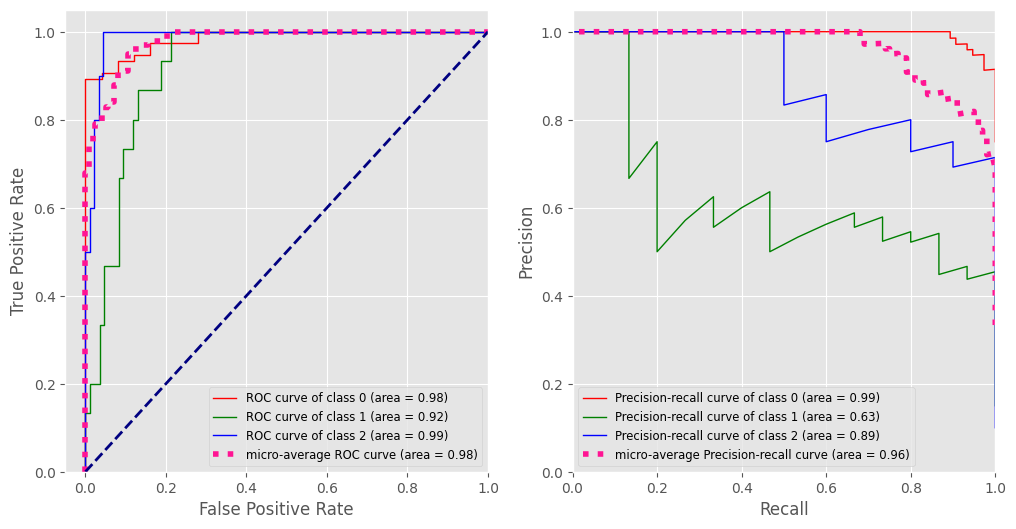

In [13]:
model = 'Random Forest B'
clf_rfcb = RandomForestClassifier(n_estimators=50, random_state=123)
gs_params = {'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'


clf_rfcb, y_pred_rfcb, y_score_rfcb = multiclass_classify(model, clf_rfcb, features_orig, params=gs_params, score=gs_score, scale=False)
print('\nBest Parameters:\n',clf_rfcb)

metrics_rfcb, prc_rfcb, roc_rfcb = multiclass_metrics(model, y_test, y_pred_rfcb, y_score_rfcb, print_out=True, plot_out=True)

After Feature Extraction


Best Parameters:
 RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=50,
                       random_state=123)
-----------------------------------------------------------
Random Forest A 

Confusion Matrix:
[[74  1  0]
 [12  3  0]
 [ 0  2  8]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92        75
           1       0.50      0.20      0.29        15
           2       1.00      0.80      0.89        10

    accuracy                           0.85       100
   macro avg       0.79      0.66      0.70       100
weighted avg       0.82      0.85      0.82       100


Metrics:
                 Random Forest A
Accuracy                0.850000
macro F1                0.705759
micro F1                0.867347
macro Precision         0.800813
micro Precision         0.885417
macro Recall            0.662222
micro Recall            0.850000
macro ROC AUC           0.967744
micro ROC AUC        

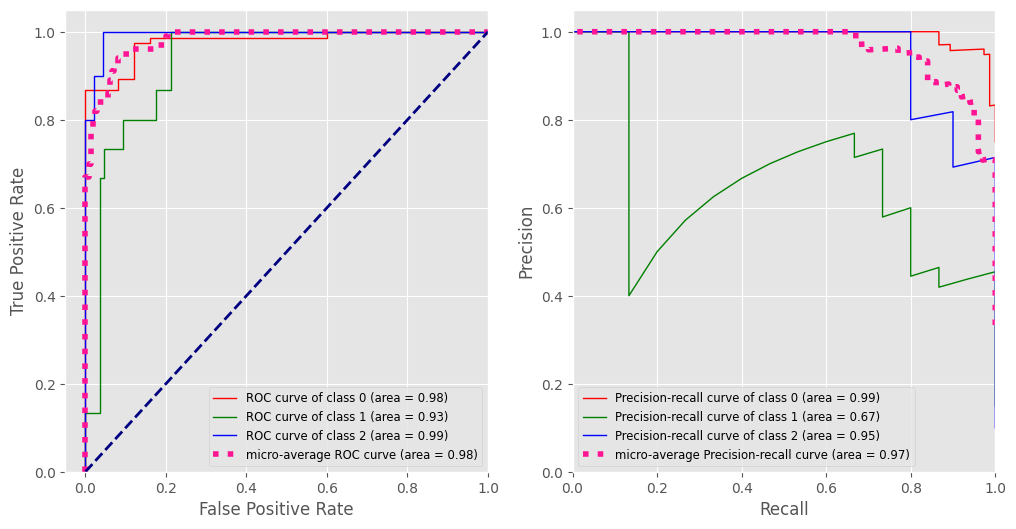

In [14]:
model = 'Random Forest A'
clf_rfca = RandomForestClassifier(n_estimators=50, random_state=123)
gs_params = {'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'


clf_rfca, y_pred_rfca, y_score_rfca = multiclass_classify(model, clf_rfca, features_extr, params=gs_params, score=gs_score, scale=False)
print('\nBest Parameters:\n',clf_rfca)

metrics_rfca, prc_rfca, roc_rfca = multiclass_metrics(model, y_test, y_pred_rfca, y_score_rfca, print_out=True, plot_out=True)



In [15]:
metrics_rfc = pd.concat([metrics_rfcb, metrics_rfca], axis=1)
metrics_rfc

,Random Forest B,Random Forest A
Accuracy,0.820000,0.850000
macro F1,0.612536,0.705759
micro F1,0.854167,0.867347
macro Precision,0.776749,0.800813
micro Precision,0.891304,0.885417
macro Recall,0.573333,0.662222
micro Recall,0.820000,0.850000
macro ROC AUC,0.964340,0.967744
micro ROC AUC,0.978550,0.980600


# Comparing all tried multiclass classification algorithms 

In [16]:
#compare all models
metrics_mc = pd.concat([metrics_lgr, metrics_dtr, metrics_rfc], axis=1).T
metrics_mc

,Accuracy,macro F1,micro F1,macro Precision,micro Precision,macro Recall,micro Recall,macro ROC AUC,micro ROC AUC
Logistic Regression B,0.81,0.552032,0.830769,0.546081,0.852632,0.562222,0.81,0.942605,0.969850
Logistic Regression A,0.81,0.551750,0.852632,0.586919,0.900000,0.533333,0.81,0.941515,0.971800
Decision Tree B,0.84,0.684053,0.861538,0.818970,0.884211,0.668889,0.84,0.905594,0.956625
Decision Tree A,0.84,0.607906,0.857143,0.852146,0.875000,0.651111,0.84,0.949857,0.973550
Random Forest B,0.82,0.612536,0.854167,0.776749,0.891304,0.573333,0.82,0.964340,0.978550
Random Forest A,0.85,0.705759,0.867347,0.800813,0.885417,0.662222,0.85,0.967744,0.980600


Neural Net Multi-layer Perceptron classifier clearly outperformed other models in all metrics, with the
Random Forests classifier scoring in the second place.

Text(0.5, 1.0, 'micro Precision Recall')

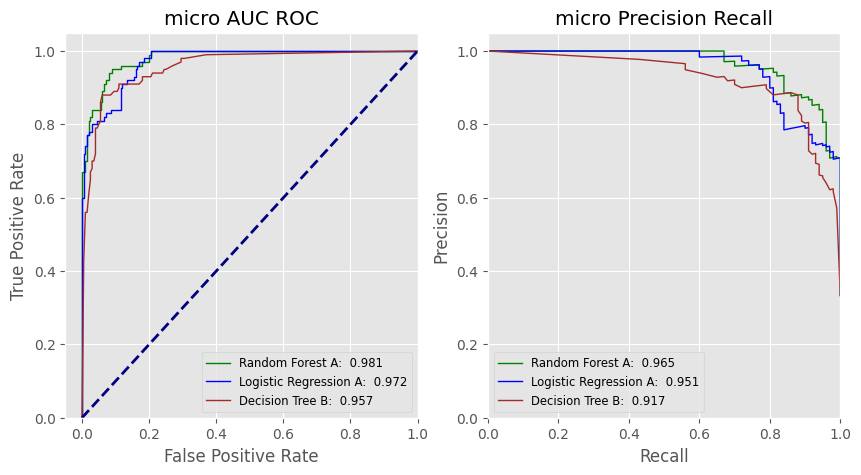

In [17]:
# Plot AUC-ROC and precision-recall curves for best models

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False )
fig.set_size_inches(10,5)
ax1.plot(roc_rfca.FPR['micro'], roc_rfca.TPR['micro'], color='green', lw=1, label= roc_rfca.Model['micro'] + ':  %.3f' % roc_rfca.AUC['micro'])
ax1.plot(roc_lgra.FPR['micro'], roc_lgra.TPR['micro'], color='blue', lw=1, label= roc_lgra.Model['micro'] + ':  %.3f' % roc_lgra.AUC['micro'])
ax1.plot(roc_dtrb.FPR['micro'], roc_dtrb.TPR['micro'], color='brown', lw=1, label= roc_dtrb.Model['micro'] + ':  %.3f' % roc_dtrb.AUC['micro'])
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([-0.05, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right", fontsize='small')
ax1.set_title('micro AUC ROC')
ax2.plot(prc_rfca.Recall['micro'], prc_rfca.Precision['micro'], color='green', lw=1, label= prc_rfca.Model['micro'] + ':  %.3f' % prc_rfca['Avg Precision']['micro'])
ax2.plot(prc_lgra.Recall['micro'], prc_lgra.Precision['micro'], color='blue', lw=1, label= prc_lgra.Model['micro'] + ':  %.3f' % prc_lgra['Avg Precision']['micro'])
ax2.plot(prc_dtrb.Recall['micro'], prc_dtrb.Precision['micro'], color='brown', lw=1, label= prc_dtrb.Model['micro'] + ':  %.3f' % prc_dtrb['Avg Precision']['micro'])
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc="lower left", fontsize='small')
ax2.set_title('micro Precision Recall')

#Multiclass Classification Summary:

1. Accuracy of Random Forest Classifier is after feature extraction is higher (85 %)
2. In terms of AUC-ROC metric, Random Forest Classifier has highest value (98.02%)